# Chapter 8 - Tree-based Methods

- [1. Regression Trees](#1.-Regression-Trees)
- [2. Classification Trees](#2.-Classification-Trees)
- [3. Bagging and Random Forests](#3.-Bagging-and-Random-Forests)
- [4. Bagging, Voting](#4.-Bagging,-Voting)

In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
# from sklearn.externals.six import StringIO  
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor, VotingClassifier
from sklearn.metrics import mean_squared_error,confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')

from visualize import plot_confusion_matrix

%matplotlib inline
plt.style.use('seaborn-white')

---
## 1. Regression Trees

### 1.1. Analze Data

In [2]:
# Load data
df = pd.read_csv('Data/Hitters.csv').dropna()
df.head(3)

Unnamed: 0  AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  CHits  \
1    -Alan Ashby    315    81      7    24   38     39     14    3449    835   
2   -Alvin Davis    479   130     18    66   72     76      3    1624    457   
3  -Andre Dawson    496   141     20    65   78     37     11    5628   1575   

   ...  CRuns  CRBI  CWalks  League Division PutOuts  Assists  Errors  Salary  \
1  ...    321   414     375       N        W     632       43      10   475.0   
2  ...    224   266     263       A        W     880       82      14   480.0   
3  ...    828   838     354       N        E     200       11       3   500.0   

   NewLeague  
1          N  
2          A  
3          N  

[3 rows x 21 columns]

In [3]:
# Prepare X, y
feature_names = ['Years', 'Hits']
X = df[feature_names].values
y = np.log(df['Salary'].values)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11,4))
ax1.hist(df['Salary'].values)
ax1.set_xlabel('Salary')
ax2.hist(y)
ax2.set_xlabel('Log (Salary)');
plt.show()

### 1.2. Train Regression Tree

In [4]:
# Training
regr = DecisionTreeRegressor(max_leaf_nodes=3)
regr.fit(X, y)

DecisionTreeRegressor(max_leaf_nodes=3)

### 1.3. Plot Tree

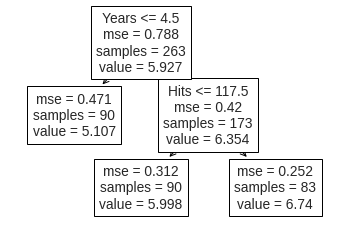

In [5]:
# Plot tree structure
res = plot_tree(regr, feature_names=feature_names)
plt.show()

### 1.4. Termination conditions

In [6]:
# Prepare  (Drop non-float columns)
X = df.drop(['Unnamed: 0', 'Salary'], axis=1)
y = df['Salary']

X.head(3)

AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  CHits  CHmRun  CRuns  \
1    315    81      7    24   38     39     14    3449    835      69    321   
2    479   130     18    66   72     76      3    1624    457      63    224   
3    496   141     20    65   78     37     11    5628   1575     225    828   

   CRBI  CWalks League Division  PutOuts  Assists  Errors NewLeague  
1   414     375      N        W      632       43      10         N  
2   266     263      A        W      880       82      14         A  
3   838     354      N        E      200       11       3         N

In [7]:
# Change string data to numerical data
X['League'], _ = X['League'].factorize()
X['Division'], _ = X['Division'].factorize()
X['NewLeague'], _ = X['NewLeague'].factorize()

X.shape, y.shape

((263, 19), (263,))

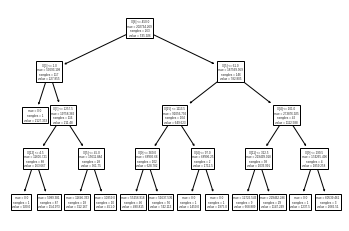

In [8]:
# max_depth
regr = DecisionTreeRegressor(max_depth=4)
regr.fit(X, y)

res = plot_tree(regr)
plt.show()

### 1.5. Exercise
Write your code in the cells below. (5min)
- Try various termination conditions.
- Ref: [DecisionTreeRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html)

---
### 1.6. Pruning

In [9]:
# Training (alpha == 5)
regr = DecisionTreeRegressor(ccp_alpha=5)
regr.fit(X, y)

res = plot_tree(regr)

In [10]:
# Training (alpha == 50)
regr = DecisionTreeRegressor(ccp_alpha=50)
regr.fit(X, y)

res = plot_tree(regr)

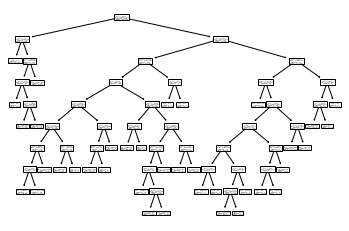

In [11]:
# Training (alpha == 500)
regr = DecisionTreeRegressor(ccp_alpha=500)
regr.fit(X, y)

res = plot_tree(regr)

### 1.7. Exercise
Write your code in the cells below. (15min)
1. Prepare train / test data
2. Calculate cross validation error with different $\alpha$. (Use Mean Square Error (MSE))
3. Calculate test error with different $\alpha$. (Use Mean Square Error (MSE))
4. Plot a Graph with the errors (X: $\alpha$, y: Test error, CV error) and get the proper $\alpha$ with CV error.

#### 1.7.1. Prepare train / test data

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(210, 19) (53, 19) (210,) (53,)


#### 1.7.2. Calculate cross validation error with different $\alpha$. (Use Mean Square Error (MSE))

In [14]:
ccp_alphas = np.exp([0.1*x for x in range(200)])

param_grid = {
    'ccp_alpha': ccp_alphas,
}
regr_1 = GridSearchCV(
    DecisionTreeRegressor(),          # Estimator(Pregressor, Classifier)
    param_grid=param_grid,            # ParamGrid
    scoring='neg_mean_squared_error', # scoring
    cv=5                              # Cross Validation
)

In [15]:
regr_1.fit(X_train, y_train)
cv_errors = -regr_1.cv_results_['mean_test_score']

#### 1.7.3. Calculate test error with different $\alpha$. (Use Mean Square Error (MSE))

In [16]:
test_errors = []
for ccp_alpha in ccp_alphas:
    regr_2 = DecisionTreeRegressor(ccp_alpha = ccp_alpha)
    y_pred = regr_2.fit(X_train, y_train).predict(X_test)
    y_true = y_test
    test_error = mean_squared_error(y_true, y_pred)
    test_errors.append(test_error)

#### 1.7.4. Plot a Graph with the errors (X: $\alpha$, y: Test error, CV error) and get the proper $\alpha$ with CV error.

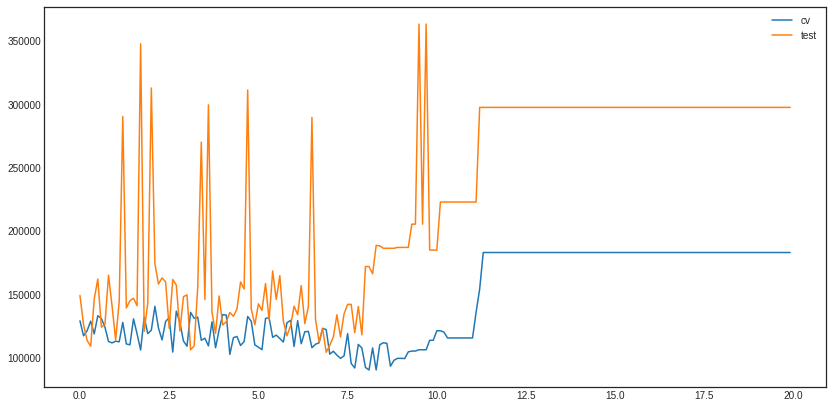

In [17]:
fig, ax = plt.subplots(figsize=(14,7))
ax.plot(np.log(ccp_alphas), cv_errors, label='cv')
ax.plot(np.log(ccp_alphas), test_errors, label='test')
ax.legend()
fig.show()

---
## 2. Classification Trees
### 2.1. Analyze Data

In [18]:
# Load data
df = pd.read_csv('Data/Heart.csv').drop('Unnamed: 0', axis=1).dropna()
df.head(3)

Age  Sex     ChestPain  RestBP  Chol  Fbs  RestECG  MaxHR  ExAng  Oldpeak  \
0   63    1       typical     145   233    1        2    150      0      2.3   
1   67    1  asymptomatic     160   286    0        2    108      1      1.5   
2   67    1  asymptomatic     120   229    0        2    129      1      2.6   

   Slope   Ca        Thal  AHD  
0      3  0.0       fixed   No  
1      2  3.0      normal  Yes  
2      2  2.0  reversable  Yes

In [19]:
# Data => X, y
X = df.drop(['AHD', 'ChestPain', 'Thal'], axis=1)
y, _ = df['AHD'].factorize()

### 2.2. Train Classification Tree

In [20]:
clf = DecisionTreeClassifier(max_leaf_nodes=6, max_features=3)
clf.fit(X, y)

DecisionTreeClassifier(max_features=3, max_leaf_nodes=6)

### 2.3. Plot Tree

In [21]:
res = plot_tree(clf, feature_names=X.columns)

### 2.4. Analyze the Result

In [22]:
clf.score(X, y) # Mean accuracy

0.7643097643097643

---
## 3. Bagging and Random Forests

### 3.1. Analyze Data
Dataset Description: https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html

In [23]:
 # Load data
df = pd.read_csv('Data/Boston.csv')
df.head(3)

crim    zn  indus  chas    nox     rm   age     dis  rad  tax  ptratio  \
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296     15.3   
1  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242     17.8   
2  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242     17.8   

    black  lstat  medv  
0  396.90   4.98  24.0  
1  396.90   9.14  21.6  
2  392.83   4.03  34.7

In [24]:
# Data => X, y
X = df.drop('medv', axis=1)
y = df.medv

# Split Train/Test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(253, 13) (253, 13) (253,) (253,)


### 3.2. Create Random Forest Regressors with Various Number of Features

In [26]:
# Using all features
regr_all = RandomForestRegressor(max_features=13, random_state=1)
# Using half features
regr_half = RandomForestRegressor(max_features=6, random_state=1)
# Using sqrt(p) features
regr_sqrt = RandomForestRegressor(max_features=4, random_state=1)

regr_all.fit(X_train, y_train)
regr_half.fit(X_train, y_train)
regr_sqrt.fit(X_train, y_train)

RandomForestRegressor(max_features=4, random_state=1)

### 3.3. Train and Evaluate the Regressors

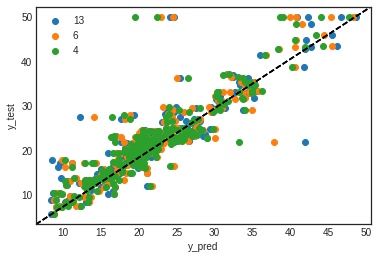

In [27]:
# Compare results
MSEs = []
for regr in [regr_all, regr_half, regr_sqrt]:
    y_pred = regr.predict(X_test)
    MSE = mean_squared_error(y_test, y_pred)
    MSEs.append(MSE)

    plt.scatter(y_pred, y_test, label=regr.max_features)
    plt.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
    plt.xlabel('y_pred')
    plt.ylabel('y_test')
plt.legend()
plt.show()

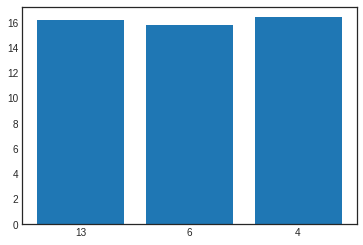

In [28]:
# Mean Square Errors
plt.bar(['13','6','4'], MSEs)
plt.show()

### 3.4. Plot Feature Importances

In [29]:
regr_all.feature_importances_

array([0.03528629, 0.00114356, 0.00794199, 0.00101602, 0.01075332,
       0.32944791, 0.01643057, 0.04369569, 0.00443421, 0.01297369,
       0.02197934, 0.01127816, 0.50361926])

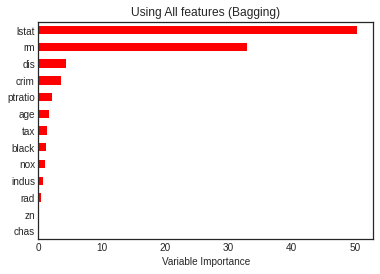

In [30]:
## Feature Importance
# Using all features
Importance = pd.DataFrame({'Importance':regr_all.feature_importances_*100}, index=X.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r', )

plt.title('Using All features (Bagging)')
plt.xlabel('Variable Importance')
plt.gca().legend_ = None
plt.show()

# Using sqrt(p) features
Importance = pd.DataFrame({'Importance':regr_sqrt.feature_importances_*100}, index=X.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r', )

plt.title('Using sqrt(p) features (RandomForest)')
plt.xlabel('Variable Importance')
plt.gca().legend_ = None
plt.show()

### 3.5. Exercise
Write your code in the cells below. (10min)<br/>
Use *Hitters* dataset (`Data/Hitters.csv`)<br/>
Predict `Salary` using other features.
1. Load data
2. Preprocess data
3. Split train / test data
4. Train random forest regressor with train data
5. Compare feature importances
6. Repeat 5~6 with test data and whole data

#### 3.5.1. Load data

In [31]:
df = pd.read_csv('Data/Hitters.csv')
df.head()

Unnamed: 0  AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  \
0     -Andy Allanson    293    66      1    30   29     14      1     293   
1        -Alan Ashby    315    81      7    24   38     39     14    3449   
2       -Alvin Davis    479   130     18    66   72     76      3    1624   
3      -Andre Dawson    496   141     20    65   78     37     11    5628   
4  -Andres Galarraga    321    87     10    39   42     30      2     396   

   CHits  ...  CRuns  CRBI  CWalks  League Division PutOuts  Assists  Errors  \
0     66  ...     30    29      14       A        E     446       33      20   
1    835  ...    321   414     375       N        W     632       43      10   
2    457  ...    224   266     263       A        W     880       82      14   
3   1575  ...    828   838     354       N        E     200       11       3   
4    101  ...     48    46      33       N        E     805       40       4   

   Salary  NewLeague  
0     NaN          A  
1   475.0          N  
2   480.0          A  
3   500.0          N  
4    91.5          N  

[5 rows x 21 columns]

#### 3.5.2. Preprocess data

#### 3.5.3. Split train / test data

#### 3.5.4. Train random forest regressor with train data

#### 3.5.5. Compare feature importances

#### 3.5.6. Repeat 5~6 with test data and whole data

### 3.6. Boosting

In [25]:
 # Load data
df = pd.read_csv('Data/Boston.csv')
df.head(3)

crim    zn  indus  chas    nox     rm   age     dis  rad  tax  ptratio  \
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296     15.3   
1  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242     17.8   
2  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242     17.8   

    black  lstat  medv  
0  396.90   4.98  24.0  
1  396.90   9.14  21.6  
2  392.83   4.03  34.7

In [26]:
# Data => X, y
X = df.drop('medv', axis=1)
y = df['medv']

# Split Train/Test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(253, 13) (253, 13) (253,) (253,)


In [27]:
regr = GradientBoostingRegressor(n_estimators=500, learning_rate=0.01, random_state=1)
regr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.01, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=1, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [28]:
# Feature Importances
feature_importance = regr.feature_importances_*100
rel_imp = pd.Series(feature_importance, index=X.columns).sort_values(inplace=False)
rel_imp.T.plot(kind='barh', color='r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

### 3.7. Exercise
Write your code in the cells below. (10min)
1. Calculate train and test errors with various Number of Trees. (Use MSE)
2. Plot graph (X: number of trees, y: train error, test error)

In [39]:
from tqdm import tqdm

In [40]:
n_estimators_list = [500*x for x in range(1, 21)]

In [41]:
train_errors, test_errors = [], []
for n_estimators in tqdm(n_estimators_list):
    regr = GradientBoostingRegressor(
        n_estimators = n_estimators, learning_rate=0.01
    )
    regr.fit(X_train, y_train)
    
    train_error = mean_squared_error(y_train, regr.predict(X_train))
    test_error = mean_squared_error(y_test, regr.predict(X_test))
    
    train_errors.append(train_error)
    test_errors.append(test_error)

100%|██████████| 20/20 [01:29<00:00,  4.47s/it]


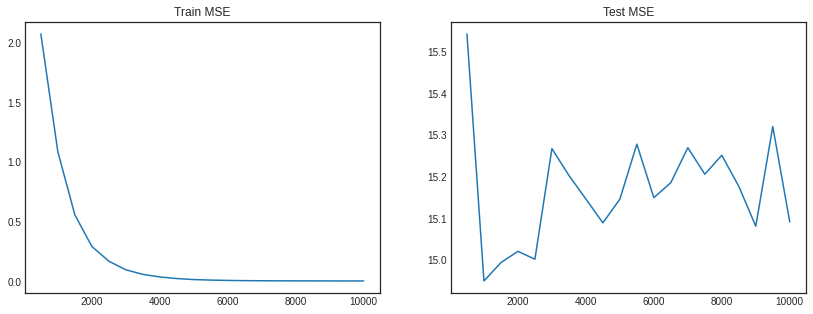

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(14,5))
ax[0].set_title('Train MSE')
ax[1].set_title('Test MSE')
ax[0].plot(n_estimators_list, train_errors)
ax[1].plot(n_estimators_list, test_errors)
fig.show()

---
## 4. Bagging, Voting
### 4.1. BaggingRegressor

In [43]:
# Load data
df = pd.read_csv('Data/Boston.csv')

# Data => X, y
X = df.drop('medv', axis=1)
y = df['medv']

# Split Train/Test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

In [44]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((253, 13), (253, 13), (253,), (253,))

23.812055335968374 16.601541501976286


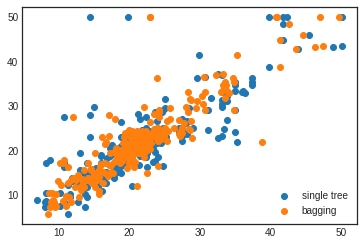

In [45]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_squared_error

regr = DecisionTreeRegressor()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

MSE_decision_tree = mean_squared_error(y_test, y_pred)
plt.scatter(y_pred, y_test, label='single tree')

regr = BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=10, random_state=0)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

MSE_bagging = mean_squared_error(y_test, y_pred)
plt.scatter(y_pred, y_test, label='bagging')
plt.legend()

print(MSE_decision_tree, MSE_bagging)

### 4.2. BaggingClassifier

In [46]:
# Load data
df = pd.read_csv('Data/Carseats.csv').drop('Unnamed: 0', axis=1)
df.head(3)

# Add High predictor
df['High'] = df['Sales'].map(lambda x: 1 if x>8 else 0)

# Change string data to numerical data
df['ShelveLoc'] = df['ShelveLoc'].map({'Bad':0, 'Medium':1, 'Good':2})
df['Urban'] = df['Urban'].map({'No':0, 'Yes':1})
df['US'] = df['US'].map({'No':0, 'Yes':1})

# Data => X, y
X = df.drop(['Sales', 'High'], axis=1)
y = df['High']

# Split train/test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)
print (X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(200, 10) (200, 10) (200,) (200,)


              precision    recall  f1-score   support

           0       0.73      0.79      0.76       118
           1       0.65      0.57      0.61        82

    accuracy                           0.70       200
   macro avg       0.69      0.68      0.68       200
weighted avg       0.70      0.70      0.70       200



              precision    recall  f1-score   support

           0       0.81      0.86      0.84       118
           1       0.78      0.71      0.74        82

    accuracy                           0.80       200
   macro avg       0.80      0.79      0.79       200
weighted avg       0.80      0.80      0.80       200



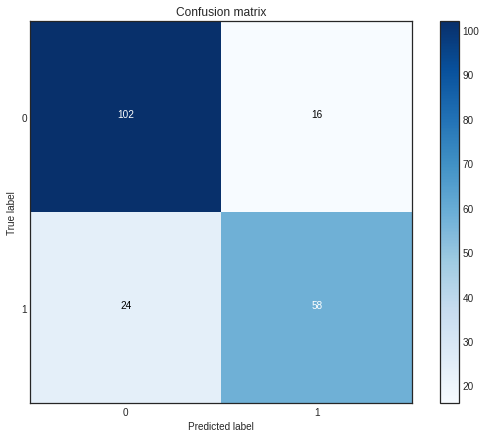

In [47]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))
plot_confusion_matrix(y_test, y_pred, target_names=clf.classes_)

clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=10, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))
plot_confusion_matrix(y_test, y_pred, target_names=clf.classes_)

### 4.3. VotingClassifier

In [34]:
clf = VotingClassifier([
    ('lr', LogisticRegression(multi_class='multinomial', random_state=0)),
    ('rf', RandomForestClassifier(n_estimators=50, random_state=0)),
    ('gnb', GaussianNB()),
], voting='hard')

clf.get_params()

{'estimators': [('lr',
   LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                      intercept_scaling=1, l1_ratio=None, max_iter=100,
                      multi_class='multinomial', n_jobs=None, penalty='l2',
                      random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                      warm_start=False)),
  ('rf',
   RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                          criterion='gini', max_depth=None, max_features='auto',
                          max_leaf_nodes=None, max_samples=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=50,
                          n_jobs=None, oob_score=False, random_state=0, verbose=0,
                          warm_start=False)),
  ('gnb', GaussianNB(priors=None, var_smoothing=1e-0

              precision    recall  f1-score   support

           0       0.84      0.92      0.87       118
           1       0.86      0.74      0.80        82

    accuracy                           0.84       200
   macro avg       0.85      0.83      0.84       200
weighted avg       0.85      0.84      0.84       200



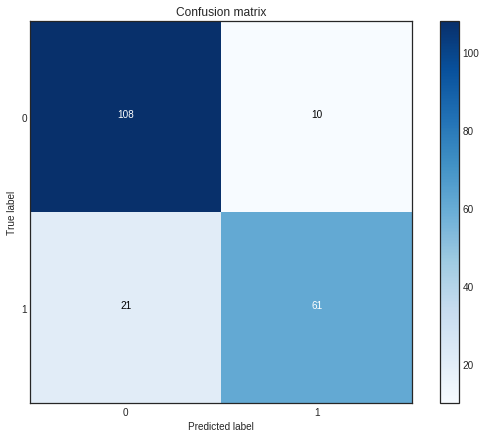

In [35]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))
plot_confusion_matrix(y_test, y_pred, target_names=clf.classes_)

### 4.4. Exercise
Write your code in the cells below.<br/>
Dataset Description: https://rdrr.io/cran/ISLR/man/Carseats.html
- Given
  1. Load *Carseats* Dataset
  2. Preprocess the Data
  3. Add `High` predictor with `Sales`
  4. Prepare X, y
  5. Split train / test data
- To do
  - Estimate test data with train data.

In [36]:
# 1. Load Carseats data
df = pd.read_csv('Data/Carseats.csv')
display(df.head(3))

# 2. Preprocess the Data
# Drop useless column
df = df.drop('Unnamed: 0', axis=1)

# Change string data to numerical data
df['ShelveLoc'] = df['ShelveLoc'].map({'Bad':0, 'Medium':1, 'Good':2})
df['Urban'] = df['Urban'].map({'No':0, 'Yes':1})
df['US'] = df['US'].map({'No':0, 'Yes':1})

# 3. Add High predictor with Sales
df['High'] = df['Sales'].map(lambda x: 1 if x > 8 else 0)
display(df.head(3))

# 4. Prepare X, y
X = df.drop(['Sales', 'High'], axis=1)
y = df['High']

# 5. Split train / test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

Unnamed: 0  Sales  CompPrice  Income  Advertising  Population  Price  \
0           1   9.50        138      73           11         276    120   
1           2  11.22        111      48           16         260     83   
2           3  10.06        113      35           10         269     80   

  ShelveLoc  Age  Education Urban   US  
0       Bad   42         17   Yes  Yes  
1      Good   65         10   Yes  Yes  
2    Medium   59         12   Yes  Yes

Sales  CompPrice  Income  Advertising  Population  Price  ShelveLoc  Age  \
0   9.50        138      73           11         276    120          0   42   
1  11.22        111      48           16         260     83          2   65   
2  10.06        113      35           10         269     80          1   59   

   Education  Urban  US  High  
0         17      1   1     1  
1         10      1   1     1  
2         12      1   1     1

In [37]:
## Estimate test data with train data


